In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
··········


In [9]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [10]:
# 코랩환경에서 작업여부를 나타내는 변수
IS_COLAB = True 

if IS_COLAB:
  path = "drive/colab/dacon_jeju_traffic/data/"
else:
  path = "I don't know yet"

print(f"path of data files is {path}")

path of data files is drive/colab/dacon_jeju_traffic/data/


In [11]:
!apt install chromium-chromedriver
!pip install selenium
!pip install eli5
!pip install shap

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (80.0.3987.149-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [12]:
ls -l drive/colab/dacon_jeju_traffic/data

total 381782
-r--r--r-- 1 root root 289504974 Nov  7 06:53  bus_bts.csv
-rw-r--r-- 1 root root   2310165 May 11  2019  jeju_financial_life_data.csv
-rw-r--r-- 1 root root      9008 Mar 30 15:10  PermutationImportance_REF.csv
-rw-r--r-- 1 root root   5982011 Mar 21 06:03 'submission_데이콘 서포터즈 1기_권영인_1주차.csv'
-rw-r--r-- 1 root root   4103729 Mar  8 12:17 'submission_데이콘 서포터즈 1기_권영인.csv'
-r--r--r-- 1 root root   2281715 Nov  7 06:39  submission_sample.csv
-r--r--r-- 1 root root  29758470 Nov  7 06:40  test.csv
-r--r--r-- 1 root root  55756093 Nov  7 06:40  train.csv
-rw-r--r-- 1 root root      1372 Mar 22 08:33  weather.csv
-r--r--r-- 1 root root   1234237 Dec 21 07:47 '행정_법정동 중심좌표.xlsx'


# [데이콘 서포터즈 1기_권영인] How much heck the bus is in jeju than seoul_2nd week

## 2주차 달성 목표

1. 전반적인 우승자 코드의 clone coding
2. statsmodel.api 와 VIF를 활용한 다중공선성 문제 해결하기
3. PCA(주성분 분석) 알아보기

### Preparing Data

In [0]:
# 주요 패키지 import

import os 
import warnings
import pandas as pd
import numpy as np
import re
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px

import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# base
# import os
import shutil
import random
# import numpy as np
import time
from collections import Counter
from sklearn.metrics import mean_squared_error

# data preprocessing
import pandas as pd
pd.set_option('max_columns', 130, 'max_rows', 30)

# visualization
# import seaborn as sns
# import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# ignore warining
# import warnings
# warnings.filterwarnings('ignore')


import folium # 지도 관련 시각화
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용


# save
from sklearn.externals import joblib 
import pickle

# selenium

# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

from selenium.webdriver import Chrome

import geopy.distance

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor

# import seaborn as sns
# import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib 
import pickle

import random
random.seed(42)

import lightgbm as lgb
from keras import metrics
from sklearn.metrics import r2_score

# 경고메시지 제거
warnings.filterwarnings(action='ignore')

#### weather crwaling

In [0]:
def crawl_weather() :
    
  #https://gist.github.com/korakot/5c8e21a5af63966d80a676af0ce15067 [Colab 환경에서 selenium을 활용한 Crawling]

  # https://wkdtjsgur100.github.io/selenium-xpath/ [Selenium을 활용한 하위객체 찾기]
  weather_data_10 = pd.DataFrame(columns=['현재일기_10','현재기온_10','일강수_10'])
  browser = webdriver.Chrome('chromedriver',options=options)
  # browser = Chrome()
  url = 'http://www.weather.go.kr/weather/observation/currentweather.jsp?auto_man=m&type=t99&reg=184&tm=2019.10.25.16%3A00&x=19&y=7'
  browser.get(url)

  for i in range(0,46):
      i+=1

      elem=browser.find_element_by_id('observation_text')
      elem.clear()
      elem.send_keys("2019.9.{}.10:00".format(i))

      btn=browser.find_elements_by_class_name('btn')
      btn[2].click()
      
      time.sleep(1)
      weathers = browser.find_elements_by_css_selector('tr')

      mean_temp_now = 0
      mean_rain_amount = 0

      for tr in weathers[2:]:
        tds = tr.find_elements_by_tag_name("td")

        if tds[0].find_element_by_tag_name("a").text == "제주":
          weather = tds[1].text

        mean_temp_now+=float(tds[5].text)
        if tds[8].text == " ":
          mean_rain_amount += 0.0
        else:
          mean_rain_amount += float(tds[8].text)

      mean_temp_now = mean_temp_now / len(weathers[2:])
      mean_rain_amount = mean_rain_amount / len(weathers[2:])

      weather_data_10  = weather_data_10.append(pd.DataFrame([[weather,mean_temp_now,mean_rain_amount]],columns=['현재일기_10','현재기온_10','일강수_10'])) 

  print('success !')
  browser.close()
  
  return weather_data_10

In [0]:
# weather_data = crawl_weather()

In [0]:
# weather_data.to_csv(path+'weather.csv', index = False)

In [0]:
weather_data = pd.read_csv(path+'weather.csv')

In [0]:
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
bts = pd.read_csv(path+"bus_bts.csv")

### EDA

#### 버스 승하차 데이터

##### day, day_type[weekday | weekend] & day_name(Mon to Sun)

In [0]:
day_type_dict = {0:"weekday",1:"weekday",2:"weekday",3:"weekday",4:"weekday",5:"weekend",6:"weekend"}
day_name_dict = {0:"Mon",1:"Tue",2:"Wed",3:"Thr",4:"Fri",5:"Sat",6:"Sun"}

train_date = train.date.value_counts().to_frame().sort_index().reset_index()
train_date.columns = ["date","count"]
train_date["month"] = "Sep"
train_date["day"] = train_date.date.apply(lambda x: x.split("-")[2])


test_date = test.date.value_counts().to_frame().sort_index().reset_index()
test_date.columns = ["date","count"]
test_date["month"] = "Oct"
test_date["day"] = test_date.date.apply(lambda x: x.split("-")[2])

# df_train_test_date = pd.concat([df_train_date,df_test_date],axis=0)
train_date["day_type"] = train_date.date.apply(lambda x: day_type_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])
train_date["day_name"] = train_date.date.apply(lambda x: day_name_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])

test_date["day_type"] = test_date.date.apply(lambda x: day_type_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])
test_date["day_name"] = test_date.date.apply(lambda x: day_name_dict[datetime.datetime.strptime(x,"%Y-%m-%d").weekday()])

In [0]:
train = pd.merge(left=train,right=train_date.loc[:,["date","day","day_type","day_name"]],how='left',on='date')
test = pd.merge(left=test,right=test_date.loc[:,["date","day","day_type","day_name"]],how='left',on='date')

In [0]:
for df in [train,test]:
  df["is_weekend"] = df["day_type"].apply(lambda x: True if x=="weekend" else False)

In [0]:
encoder = OneHotEncoder()
encoded_day_type = encoder.fit_transform(train["day_name"].values.reshape(-1,1))
dummy = pd.DataFrame(encoded_day_type.todense(),columns=map(lambda x:x[3:] ,encoder.get_feature_names()))
dummy = dummy.loc[:,dummy.columns[:-1]]
train = pd.concat([train,dummy],axis=1)

encoded_day_type = encoder.transform(test["day_name"].values.reshape(-1,1))
dummy = pd.DataFrame(encoded_day_type.todense(),columns=map(lambda x:x[3:] ,encoder.get_feature_names()))
dummy = dummy.loc[:,dummy.columns[:-1]]
test = pd.concat([test,dummy],axis=1)

##### 공휴일

In [0]:
hoillday_date_list = ["2019-09-12","2019-09-13","2019-09-14","2019-10-03","2019-10-09"]

def filter_hoilday(strdate,list):

  if strdate in list:
    return True
  else:
    return False

In [0]:
train["is_holiday"] =train.date.map(lambda x: filter_hoilday(x,hoillday_date_list))
test["is_holiday"] =test.date.map(lambda x: filter_hoilday(x,hoillday_date_list))

##### 요일 및 평일/주말에 따른 시간대별 총 승하차 인원 수

In [0]:
geton_timeline_list = train.columns[8:14]
takeoff_timeline_list = train.columns[14:20]

In [0]:
def day_name_type_sum (df):

  # 요일별 승차 합
  f = df.groupby("day_name")[geton_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_name_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left",on="day_name")

  # 요일별 승차 평균
  f = df.groupby("day_name")[geton_timeline_list].agg("mean").reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_name_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left",on="day_name")

  # 요일별 하차 합
  f = df.groupby("day_name")[takeoff_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_name_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  # 요일별 하차 평균
  f = df.groupby("day_name")[takeoff_timeline_list].agg("mean").reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_name_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  # 평/공휴일 별 승차 합
  f = df.groupby("day_type")[geton_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_type_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  # 평/공휴일 별 승차 평균
  f = df.groupby("day_type")[geton_timeline_list].agg("mean").reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_type_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  # 평/공휴일 별 하차 합
  f = df.groupby("day_type")[takeoff_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_type_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  # 평/공휴일 별 하차 평균
  f = df.groupby("day_type")[takeoff_timeline_list].agg("mean").reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"day_type_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  return df

In [0]:
train = day_name_type_sum(train)
test = day_name_type_sum(test)

In [61]:
train.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

##### 시내/시외 버스별 평균 승하차인원

In [0]:
def in_out_bus_ride_takeoff_mean_sum(df):
  
  f = df.groupby("in_out")[geton_timeline_list].mean().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"in_out_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  f = df.groupby("in_out")[geton_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"in_out_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  f = df.groupby("in_out")[takeoff_timeline_list].mean().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"in_out_"+x+"_mean",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  f = df.groupby("in_out")[takeoff_timeline_list].sum().reset_index()
  f.columns = [f.columns[0]] + list(map(lambda x:"in_out_"+x+"_sum",f.columns[1:]))
  df = pd.merge(left=df,right=f,how="left")

  return df

In [0]:
train = in_out_bus_ride_takeoff_mean_sum(train)
test = in_out_bus_ride_takeoff_mean_sum(test)

##### 좌표데이터를 이용한 변수

In [0]:
def geological_convert(loc_cat):
  if loc_cat==0:
    return 'jeju'
  elif loc_cat==1:
    return 'gosan'
  elif loc_cat==2:
    return 'seongsan'
  else:
    return 'po'

def geological_encoding(df):

  data = df.copy()

  jeju=(33.51411, 126.52969) # 제주 측정소 근처
  gosan=(33.29382, 126.16283) #고산 측정소 근처
  seongsan=(33.38677, 126.8802) #성산 측정소 근처
  po=(33.24616, 126.5653) #서귀포 측정소 근처
  
  print("#"*10,"jeju processing")
  t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
  print("#"*10,"gosan processing")
  t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
  print("#"*10,"seongsan processing")
  t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]
  print("#"*10,"seoguipo processing")
  t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( data['latitude'],data['longitude'] )) ]

  data['dis_jeju'] = t1
  data['dis_gosan']=t2
  data['dis_seongsan']=t3
  data['dis_po']=t4

  print("#"*5,"result aggregating processing")
  total = pd.DataFrame(list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
  data['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
  data['dist_name'] = data['dist_name'].apply(lambda x:geological_convert(x))

  print("#"*5,"geological converting done")
    
  return data

In [65]:
train = geological_encoding(train)
test = geological_encoding(test)

########## jeju processing
########## gosan processing
########## seongsan processing
########## seoguipo processing
##### result aggregating processing
##### geological converting done
########## jeju processing
########## gosan processing
########## seongsan processing
########## seoguipo processing
##### result aggregating processing
##### geological converting done


In [66]:
train.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

In [0]:
encoder = OneHotEncoder()
encoded_day_type = encoder.fit_transform(train["dist_name"].values.reshape(-1,1))
dummy = pd.DataFrame(encoded_day_type.todense(),columns=map(lambda x:x[3:] ,encoder.get_feature_names()))
dummy = dummy.loc[:,dummy.columns[:-1]]
train = pd.concat([train,dummy],axis=1)

encoded_day_type = encoder.transform(test["dist_name"].values.reshape(-1,1))
dummy = pd.DataFrame(encoded_day_type.todense(),columns=map(lambda x:x[3:] ,encoder.get_feature_names()))
dummy = dummy.loc[:,dummy.columns[:-1]]
test = pd.concat([test,dummy],axis=1)

In [0]:
dummy.head()

gosan  jeju   po
0    0.0   1.0  0.0
1    0.0   1.0  0.0
2    0.0   1.0  0.0
3    0.0   1.0  0.0
4    0.0   0.0  1.0

##### 출근 시간의 총 승객 수

In [0]:
geton_timeline_list = train.columns[8:14]
takeoff_timeline_list = train.columns[14:20]

for df in [train,test]:

  df["ride_sum"] = df.loc[:,geton_timeline_list].sum(axis=1)
  df["takeoff_sum"]= df.loc[:,takeoff_timeline_list].sum(axis=1)

##### 날짜 및 시간대 별 총 승객 수

In [0]:
def geton_timeline_sum(df):
  for element in geton_timeline_list:
    f = df.groupby("date")[element].agg([(element+"_date_sum","sum")]).reset_index()
    df = pd.merge(left=df,right=f,how="left",on="date")

  return df

In [0]:
train= geton_timeline_sum(train)
test = geton_timeline_sum(test)

##### 승하차 시간대 시간단위 추가 (t~t+2)


In [0]:
for df in [train,test]:

  df["6~8r"] = df["6~7_ride"] + df["7~8_ride"]
  df["8~10r"] = df["8~9_ride"] + df["9~10_ride"]
  df["10~12r"] = df["10~11_ride"] + df["11~12_ride"]

  df["6~8t"] = df["6~7_takeoff"] + df["7~8_takeoff"]
  df["8~10t"] = df["8~9_takeoff"] + df["9~10_takeoff"]
  df["10~12t"] = df["10~11_takeoff"] + df["11~12_takeoff"]

#### Target Value를 활용한 집계성 컬럼 생성 (1)

Target Value를 통해 집계성 컬럼 생성이 가능한 이유는, 하나의 Row는 ID로 구분이 되지만 실질적인 구분자는 date,bus_route_id,station_code의 조합이기 때문이다.

In [0]:
train["route_station_code"] = train["bus_route_id"].astype("str")+"_"+train["station_code"].astype("str")
test["route_station_code"] = test["bus_route_id"].astype("str")+"_"+test["station_code"].astype("str")

In [0]:
column_list = ["bus_route_id","station_code","route_station_code"]

for element in column_list:
  agg_train= train.groupby(element)["18~20_ride"].agg([(element+"_mean","mean"),(element+"_sum","sum")]).reset_index()

  train = pd.merge(left=train,right=agg_train,how="left",on=element)
  test = pd.merge(left=test,right=agg_train,how="left",on=element)

  test[element+"_mean"] = test[element+"_mean"].fillna(agg_train[element+"_mean"].mean())
  test[element+"_sum"] = test[element+"_sum"].fillna(agg_train[element+"_sum"].mean())

#### Target Value를 활용한 집계성 컬럼 생성 (2) - 혼잡도 계산

In [0]:
congestion = train.groupby("bus_route_id")["18~20_ride"].agg([("passenger","sum")]).astype("int64").reset_index()

def congestion_level_converter(passenger):
  if passenger > 10000:
    return 7
  elif passenger > 5000:
    return 6
  elif passenger > 2000:
    return 5
  elif passenger > 700:
    return 4
  elif passenger > 200:
    return 3
  elif passenger > 50:
    return 2
  else:
    return 1

congestion["congestion"] = congestion.passenger.apply(lambda x: congestion_level_converter(x))

train = pd.merge(left=train,right=congestion.loc[:,["bus_route_id","congestion"]],how="left",on="bus_route_id")
test = pd.merge(left=test,right=congestion.loc[:,["bus_route_id","congestion"]],how="left",on="bus_route_id")

test["congestion"]= test["congestion"].fillna(train["congestion"].median())

In [77]:
train.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

#### route_station_code를 활용한 전 시간대 별 집계성 컬럼 생성

In [78]:
timeline_columns = list(train.columns[8:20])
timeline_columns

['6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff']

In [0]:
timeline_columns = list(train.columns[8:20])

for element in timeline_columns:
  agg_train =train.groupby("route_station_code")[element].agg([(element+"_mean","mean"),(element+"_sum","sum")]).reset_index()

  train = pd.merge(left=train,right=agg_train,how="left",on="route_station_code")
  test = pd.merge(left=test,right=agg_train,how="left",on="route_station_code")
  
  test[element+"_mean"] = test[element+"_mean"].fillna(agg_train[element+"_mean"].mean())
  test[element+"_sum"] = test[element+"_sum"].fillna(agg_train[element+"_sum"].mean())

#### Categorical value makes Category

In [0]:
encoder = LabelEncoder()

train["is_train"] = True
test["is_train"] = False

train_columns = train.columns

data = pd.concat([train,test],axis=0)
data = data.loc[:,train_columns]

column_list = ["bus_route_id","in_out","station_code","route_station_code"]

encoded_column_dict = dict()

for element in column_list:
  encoded = encoder.fit_transform(data[element])
  encoded_column_dict[element] = encoder.classes_

  data["encoded_"+element] = encoded

In [81]:
data.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

In [82]:

encoded_column_dict

{'bus_route_id': array([ 4270000,  4280000,  7990000,  8170000,  8180000,  8880000,
        17010000, 20010000, 20020000, 20040000, 20050000, 21000000,
        21010000, 21020000, 21040000, 21070000, 21080000, 21090000,
        21100000, 21110000, 21120000, 21150000, 21160000, 21180000,
        21200000, 21220000, 21230000, 21270000, 21290000, 21300000,
        21310000, 21330000, 21340000, 21350000, 21360000, 21370000,
        21390000, 21400000, 21410000, 21420000, 21430000, 21440000,
        21450000, 21460000, 21470000, 21480000, 21500000, 21510000,
        21520000, 21540000, 21550000, 21570000, 21580000, 21590000,
        21600000, 21610000, 21620000, 21720000, 21780000, 21790000,
        21800000, 21810000, 21820000, 21830000, 21850000, 21860000,
        21880000, 21900000, 21910000, 21920000, 21930000, 21940000,
        21950000, 21970000, 21980000, 22180000, 22190000, 22200000,
        22210000, 22220000, 22230000, 22240000, 22250000, 22340000,
        22350000, 22360000, 2237

#### 버스카드 승하차 태그 데이터

##### 버스 승하차 태그시간 변환

In [0]:
def time_converter(str_time,is_geton=True):
  
  result = ""

  if is_geton:

    add_str = "_ride"

    if str_time >= '06:00:00' and str_time < '07:00:00':
      result = f"6~7{add_str}"
    elif str_time >= '07:00:00' and str_time < '08:00:00':
      result = f"7~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '09:00:00':
      result = f"8~9{add_str}"
    elif str_time >= '09:00:00' and str_time < '10:00:00':
      result = f"9~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '11:00:00':
      result = f"10~11{add_str}"
    elif str_time >= '11:00:00' and str_time < '12:00:00':
      result = f"11~12{add_str}"

  else:

    add_str = "_takeoff"

    if str_time is None:
      result = "NaN"
    elif str_time >= '06:00:00' and str_time < '07:00:00':
      result = f"6~7{add_str}"
    elif str_time >= '07:00:00' and str_time < '08:00:00':
      result = f"7~8{add_str}"
    elif str_time >= '08:00:00' and str_time < '09:00:00':
      result = f"8~9{add_str}"
    elif str_time >= '09:00:00' and str_time < '10:00:00':
      result = f"9~10{add_str}"
    elif str_time >= '10:00:00' and str_time < '11:00:00':
      result = f"10~11{add_str}"
    elif str_time >= '11:00:00' and str_time < '12:00:00':
      result = f"11~12{add_str}"
    elif str_time >= '12:00:00' and str_time < '13:00:00':
      result = f"12~13{add_str}"
    elif str_time >= '13:00:00' and str_time < '14:00:00':
      result = f"13~14{add_str}"
    elif str_time >= '14:00:00' and str_time < '15:00:00':
      result = f"14~15{add_str}"
    elif str_time >= '15:00:00' and str_time < '16:00:00':
      result = f"15~16{add_str}"

  return result

In [0]:
bts["timeline"] = bts.geton_time.apply(lambda x:time_converter(x))

##### 카테고리별 총 승차인원

In [85]:
dummy = bts.groupby(["bus_route_id","user_category"])["user_count"].sum().reset_index()
df_bus_user_cat = pd.pivot_table(data=dummy,index="bus_route_id",columns="user_category",values="user_count",aggfunc=np.max).fillna(0)
df_bus_user_cat.columns = list(map(lambda x:"user_cat_sum_"+str(x),df_bus_user_cat.columns))
data = pd.merge(left=data,right=df_bus_user_cat,how='left',on='bus_route_id')
data.loc[:,df_bus_user_cat.columns] = data.loc[:,df_bus_user_cat.columns].fillna(0)
data

id        date  bus_route_id in_out  station_code   station_name  \
0            0  2019-09-01       4270000     시외           344          제주썬호텔   
1            1  2019-09-01       4270000     시외           357           한라병원   
2            2  2019-09-01       4270000     시외           432           정존마을   
3            3  2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4  2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...         ...           ...    ...           ...            ...   
643588  643588  2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
643589  643589  2019-10-16      32820000     시내          1080         애월고등학교   
643590  643590  2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
643591  643591  2019-10-16      32820000     시내          1564      제주시외버스터미널   
643592  643592  2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  \
0       33.48990  126.49373       0.0       1.0       2.0        5.0   
1       33.48944  126.48508       1.0       4.0       4.0        2.0   
2       33.48181  126.47352       1.0       1.0       0.0        2.0   
3       33.50577  126.49252       0.0      17.0       6.0       26.0   
4       33.25579  126.41260       0.0       0.0       0.0        0.0   
...          ...        ...       ...       ...       ...        ...   
643588  33.30073  126.18044       0.0       0.0       0.0        0.0   
643589  33.46262  126.33447       0.0       0.0       0.0        0.0   
643590  33.41437  126.26336       3.0       0.0       0.0        0.0   
643591  33.49946  126.51479       3.0       0.0       0.0        0.0   
643592  33.24873  126.50799       0.0       0.0       0.0        0.0   

        10~11_ride  11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  \
0              2.0         6.0          0.0          0.0          0.0   
1              5.0         6.0          0.0          0.0          0.0   
2              0.0         0.0          0.0          0.0          0.0   
3             14.0        16.0          0.0          0.0          0.0   
4              0.0         0.0          0.0          0.0          0.0   
...            ...         ...          ...          ...          ...   
643588         0.0         0.0          0.0          3.0          0.0   
643589         0.0         0.0          1.0          0.0          0.0   
643590         0.0         0.0          0.0          0.0          0.0   
643591         0.0         0.0          0.0          0.0          0.0   
643592         0.0         0.0          0.0          0.0          3.0   

        9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride day day_type  \
0                0.0            0.0            0.0         0.0  01  weekend   
1                0.0            0.0            0.0         5.0  01  weekend   
2                0.0            0.0            0.0         2.0  01  weekend   
3                0.0            0.0            0.0        53.0  01  weekend   
4                1.0            0.0            0.0         0.0  01  weekend   
...              ...            ...            ...         ...  ..      ...   
643588           0.0            0.0            0.0         NaN  16  weekday   
643589           0.0            0.0            0.0         NaN  16  weekday   
643590           0.0            0.0            0.0         NaN  16  weekday   
643591           0.0            0.0            0.0         NaN  16  weekday   
643592           0.0            0.0            0.0         NaN  16  weekday   

       day_name  is_weekend  Fri  Mon  Sat  Sun  Thr  Tue  is_holiday  \
0           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
1           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
2           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
3           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       Fals

##### 카테고리별 승객 비율

In [86]:
dummy = bts.groupby(["bus_route_id","user_category"])["user_count"].sum().reset_index()
dummy.columns = list(dummy.columns[:2]) + ["user_count_by_cat"]
dummy2 = bts.groupby(["bus_route_id"])["user_count"].sum().reset_index()
dummy2.columns = list(dummy2.columns[:1]) + ["user_count_total"]

df_user_cat_ratio = pd.merge(left=dummy,right=dummy2,how='inner',on='bus_route_id')
df_user_cat_ratio["user_cat_ratio"] = df_user_cat_ratio["user_count_by_cat"] / df_user_cat_ratio["user_count_total"]
df_user_cat_ratio = pd.pivot_table(data=df_user_cat_ratio,values="user_cat_ratio",index="bus_route_id",columns="user_category",aggfunc=np.max,fill_value=0)
df_user_cat_ratio.columns = list(map(lambda x:"user_cat_ratio_"+str(x),df_user_cat_ratio.columns))
data = pd.merge(left=data,right=df_user_cat_ratio,how='left',on='bus_route_id')
data.loc[:,df_user_cat_ratio.columns] = data.loc[:,df_user_cat_ratio.columns].fillna(0)
data

id        date  bus_route_id in_out  station_code   station_name  \
0            0  2019-09-01       4270000     시외           344          제주썬호텔   
1            1  2019-09-01       4270000     시외           357           한라병원   
2            2  2019-09-01       4270000     시외           432           정존마을   
3            3  2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4  2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...         ...           ...    ...           ...            ...   
643588  643588  2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
643589  643589  2019-10-16      32820000     시내          1080         애월고등학교   
643590  643590  2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
643591  643591  2019-10-16      32820000     시내          1564      제주시외버스터미널   
643592  643592  2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  \
0       33.48990  126.49373       0.0       1.0       2.0        5.0   
1       33.48944  126.48508       1.0       4.0       4.0        2.0   
2       33.48181  126.47352       1.0       1.0       0.0        2.0   
3       33.50577  126.49252       0.0      17.0       6.0       26.0   
4       33.25579  126.41260       0.0       0.0       0.0        0.0   
...          ...        ...       ...       ...       ...        ...   
643588  33.30073  126.18044       0.0       0.0       0.0        0.0   
643589  33.46262  126.33447       0.0       0.0       0.0        0.0   
643590  33.41437  126.26336       3.0       0.0       0.0        0.0   
643591  33.49946  126.51479       3.0       0.0       0.0        0.0   
643592  33.24873  126.50799       0.0       0.0       0.0        0.0   

        10~11_ride  11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  \
0              2.0         6.0          0.0          0.0          0.0   
1              5.0         6.0          0.0          0.0          0.0   
2              0.0         0.0          0.0          0.0          0.0   
3             14.0        16.0          0.0          0.0          0.0   
4              0.0         0.0          0.0          0.0          0.0   
...            ...         ...          ...          ...          ...   
643588         0.0         0.0          0.0          3.0          0.0   
643589         0.0         0.0          1.0          0.0          0.0   
643590         0.0         0.0          0.0          0.0          0.0   
643591         0.0         0.0          0.0          0.0          0.0   
643592         0.0         0.0          0.0          0.0          3.0   

        9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride day day_type  \
0                0.0            0.0            0.0         0.0  01  weekend   
1                0.0            0.0            0.0         5.0  01  weekend   
2                0.0            0.0            0.0         2.0  01  weekend   
3                0.0            0.0            0.0        53.0  01  weekend   
4                1.0            0.0            0.0         0.0  01  weekend   
...              ...            ...            ...         ...  ..      ...   
643588           0.0            0.0            0.0         NaN  16  weekday   
643589           0.0            0.0            0.0         NaN  16  weekday   
643590           0.0            0.0            0.0         NaN  16  weekday   
643591           0.0            0.0            0.0         NaN  16  weekday   
643592           0.0            0.0            0.0         NaN  16  weekday   

       day_name  is_weekend  Fri  Mon  Sat  Sun  Thr  Tue  is_holiday  \
0           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
1           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
2           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
3           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       Fals

##### 날짜별 특정 노선의 정류장을 지나간 배차된 차량의 수

In [0]:
list_geton = ['user_card_id', 'bus_route_id', 'vhc_id', 'geton_date', 'geton_time',
       'geton_station_code', 'geton_station_name','user_category', 'user_count']
list_getoff = ['user_card_id', 'bus_route_id', 'vhc_id', 'getoff_date',
       'getoff_time', 'getoff_station_code', 'getoff_station_name',
       'user_category', 'user_count']

df_bus_bts_geton = bts.loc[:,list_geton]
df_bus_bts_getoff = bts.loc[:,list_getoff]

In [0]:
list_df_bus_bts_geton_index_col = ["geton_date","bus_route_id","geton_station_code"]
list_df_bus_bts_getoff_index_col = ["getoff_date","bus_route_id","getoff_station_code"]

In [0]:
df_bus_bts_geton_passby = df_bus_bts_geton.groupby(list_df_bus_bts_geton_index_col)["vhc_id"].count().to_frame()
df_bus_bts_geton_passby.columns = ["geton_vhc_passby_count"]

df_bus_bts_getoff_passby = df_bus_bts_getoff.groupby(list_df_bus_bts_getoff_index_col)["vhc_id"].count().to_frame()
df_bus_bts_getoff_passby.columns = ["getoff_vhc_passby_count"]

In [0]:
df_bus_bts_geton_passby = df_bus_bts_geton_passby.reset_index()
df_bus_bts_getoff_passby = df_bus_bts_getoff_passby.reset_index()

df_bus_bts_geton_passby["geton_vhc_passby_count"].fillna(value=0,inplace=True)
df_bus_bts_getoff_passby["getoff_vhc_passby_count"].fillna(value=0,inplace=True)

In [91]:
data.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

In [0]:
data = pd.merge(left=data,right=df_bus_bts_geton_passby,how='left',left_on=["date","bus_route_id","station_code"],right_on=list_df_bus_bts_geton_index_col)
data.drop(columns=["geton_date","geton_station_code"],axis=1,inplace=True)
data["geton_vhc_passby_count"] = data["geton_vhc_passby_count"].fillna(0)

data = pd.merge(left=data,right=df_bus_bts_getoff_passby,how='left',left_on=["date","bus_route_id","station_code"],right_on=list_df_bus_bts_getoff_index_col)
data.drop(columns=["getoff_date","getoff_station_code"],axis=1,inplace=True)
data["getoff_vhc_passby_count"] = data["getoff_vhc_passby_count"].fillna(0)

### 날씨 데이터

##### 날씨 데이터 병합

In [0]:
weather_data.index = pd.date_range(start="2019-09-01",end="2019-10-16")
weather_data = weather_data.reset_index()
weather_data.columns = ["date"] + list(weather_data.columns[1:])
weather_data["date"]  = weather_data["date"].astype("str")
data = pd.merge(left=data,right=weather_data,how="left",on="date")

##### 강수 여부

In [0]:
data["is_rain"] = data["일강수_10"].apply(lambda x: False if x == 0 else True)

In [0]:
encoder = OneHotEncoder()
encoded_weather = encoder.fit_transform(data["현재일기_10"].values.reshape(-1,1))
dummy = pd.DataFrame(encoded_weather.todense(),columns=map(lambda x:x[3:] ,encoder.get_feature_names()))
dummy = dummy.loc[:,dummy.columns[:-1]]
data = pd.concat([data,dummy],axis=1)

In [96]:
data

id        date  bus_route_id in_out  station_code   station_name  \
0            0  2019-09-01       4270000     시외           344          제주썬호텔   
1            1  2019-09-01       4270000     시외           357           한라병원   
2            2  2019-09-01       4270000     시외           432           정존마을   
3            3  2019-09-01       4270000     시내          1579   제주국제공항(600번)   
4            4  2019-09-01       4270000     시내          1646       중문관광단지입구   
...        ...         ...           ...    ...           ...            ...   
643588  643588  2019-10-16      32820000     시내           786  고산환승정류장(고산1리)   
643589  643589  2019-10-16      32820000     시내          1080         애월고등학교   
643590  643590  2019-10-16      32820000     시내          1129   한림환승정류장(한림리)   
643591  643591  2019-10-16      32820000     시내          1564      제주시외버스터미널   
643592  643592  2019-10-16      32820000     시내       6115100     서귀포시외버스터미널   

        latitude  longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  \
0       33.48990  126.49373       0.0       1.0       2.0        5.0   
1       33.48944  126.48508       1.0       4.0       4.0        2.0   
2       33.48181  126.47352       1.0       1.0       0.0        2.0   
3       33.50577  126.49252       0.0      17.0       6.0       26.0   
4       33.25579  126.41260       0.0       0.0       0.0        0.0   
...          ...        ...       ...       ...       ...        ...   
643588  33.30073  126.18044       0.0       0.0       0.0        0.0   
643589  33.46262  126.33447       0.0       0.0       0.0        0.0   
643590  33.41437  126.26336       3.0       0.0       0.0        0.0   
643591  33.49946  126.51479       3.0       0.0       0.0        0.0   
643592  33.24873  126.50799       0.0       0.0       0.0        0.0   

        10~11_ride  11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  \
0              2.0         6.0          0.0          0.0          0.0   
1              5.0         6.0          0.0          0.0          0.0   
2              0.0         0.0          0.0          0.0          0.0   
3             14.0        16.0          0.0          0.0          0.0   
4              0.0         0.0          0.0          0.0          0.0   
...            ...         ...          ...          ...          ...   
643588         0.0         0.0          0.0          3.0          0.0   
643589         0.0         0.0          1.0          0.0          0.0   
643590         0.0         0.0          0.0          0.0          0.0   
643591         0.0         0.0          0.0          0.0          0.0   
643592         0.0         0.0          0.0          0.0          3.0   

        9~10_takeoff  10~11_takeoff  11~12_takeoff  18~20_ride day day_type  \
0                0.0            0.0            0.0         0.0  01  weekend   
1                0.0            0.0            0.0         5.0  01  weekend   
2                0.0            0.0            0.0         2.0  01  weekend   
3                0.0            0.0            0.0        53.0  01  weekend   
4                1.0            0.0            0.0         0.0  01  weekend   
...              ...            ...            ...         ...  ..      ...   
643588           0.0            0.0            0.0         NaN  16  weekday   
643589           0.0            0.0            0.0         NaN  16  weekday   
643590           0.0            0.0            0.0         NaN  16  weekday   
643591           0.0            0.0            0.0         NaN  16  weekday   
643592           0.0            0.0            0.0         NaN  16  weekday   

       day_name  is_weekend  Fri  Mon  Sat  Sun  Thr  Tue  is_holiday  \
0           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
1           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
2           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       False   
3           Sun        True  0.0  0.0  0.0  1.0  0.0  0.0       Fals

#### Frequency Encoding

In [97]:
encoded_col_list = [e for e in list(data.columns) if "encoded_" in e]
encoded_col_list

['encoded_bus_route_id',
 'encoded_in_out',
 'encoded_station_code',
 'encoded_route_station_code']

In [98]:
high_cat_col_list = list(data.loc[:,encoded_col_list].columns[data.loc[:,encoded_col_list].nunique() > 100])
data.loc[:,high_cat_col_list]

encoded_bus_route_id  encoded_station_code  encoded_route_station_code
0                          0                   322                       31053
1                          0                   335                       31054
2                          0                   408                       31057
3                          0                  1448                       31020
4                          0                  1510                       31022
...                      ...                   ...                         ...
643588                   630                   734                       31016
643589                   630                   995                       31001
643590                   630                  1044                       31002
643591                   630                  1433                       31003
643592                   630                  3599                       31014

[643593 rows x 3 columns]

In [0]:
def frequency_encoding(series):
  
  dummy = series.value_counts().to_frame()
  dummy["total_count"] = series.value_counts().sum()
  dummy["frequency_encoded"] = series / dummy["total_count"]

  result = dummy["frequency_encoded"].reset_index() 
  result.columns = [series.name,f"{series.name}_frequency_encoded"]
  
  return result

In [100]:
frequency_encoding(data["encoded_bus_route_id"])

encoded_bus_route_id  encoded_bus_route_id_frequency_encoded
0                     328                                0.000057
1                     326                                0.000057
2                     327                                0.000057
3                     344                                0.000059
4                     343                                0.000059
..                    ...                                     ...
626                   599                                0.000115
627                   379                                0.000064
628                   352                                0.000061
629                   230                                0.000036
630                   493                                0.000085

[631 rows x 2 columns]

In [101]:
for column in data.loc[:,high_cat_col_list].columns:
  result = frequency_encoding(data[column])
  data = pd.merge(left=data,right=result,how="left",on=column)
  data.drop(column,axis=1,inplace=True)

data.head()

id        date  bus_route_id in_out  station_code  station_name  latitude  \
0   0  2019-09-01       4270000     시외           344         제주썬호텔  33.48990   
1   1  2019-09-01       4270000     시외           357          한라병원  33.48944   
2   2  2019-09-01       4270000     시외           432          정존마을  33.48181   
3   3  2019-09-01       4270000     시내          1579  제주국제공항(600번)  33.50577   
4   4  2019-09-01       4270000     시내          1646      중문관광단지입구  33.25579   

   longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  11~12_ride  \
0  126.49373       0.0       1.0       2.0        5.0         2.0         6.0   
1  126.48508       1.0       4.0       4.0        2.0         5.0         6.0   
2  126.47352       1.0       1.0       0.0        2.0         0.0         0.0   
3  126.49252       0.0      17.0       6.0       26.0        14.0        16.0   
4  126.41260       0.0       0.0       0.0        0.0         0.0         0.0   

   6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0          0.0          0.0          0.0           0.0            0.0   
1          0.0          0.0          0.0           0.0            0.0   
2          0.0          0.0          0.0           0.0            0.0   
3          0.0          0.0          0.0           0.0            0.0   
4          0.0          0.0          0.0           1.0            0.0   

   11~12_takeoff  18~20_ride day day_type day_name  is_weekend  Fri  Mon  Sat  \
0            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   
1            0.0         5.0  01  weekend      Sun        True  0.0  0.0  0.0   
2            0.0         2.0  01  weekend      Sun        True  0.0  0.0  0.0   
3            0.0        53.0  01  weekend      Sun        True  0.0  0.0  0.0   
4            0.0         0.0  01  weekend      Sun        True  0.0  0.0  0.0   

   Sun  Thr  Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  1.0  0.0  0.0       False                11548.0                18916.0   
1  1.0  0.0  0.0       False                11548.0                18916.0   
2  1.0  0.0  0.0       False                11548.0                18916.0   
3  1.0  0.0  0.0       False                11548.0                18916.0   
4  1.0  0.0  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   

In [102]:
encoded_col_list = [e for e in list(data.columns) if "encoded_" in e]
encoded_col_list

['encoded_in_out',
 'encoded_bus_route_id_frequency_encoded',
 'encoded_station_code_frequency_encoded',
 'encoded_route_station_code_frequency_encoded']

### <a href="https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection">Feature Selection</a>

EDA를 통해 다양한 의미 있고 다양한 Feature를 생성하는 것도 중요하지만, 실제 모델에 투입할 때 최적의 컬럼셋은 무엇일지를 결정하는 Selection 과정도 중요하다. generation한 만큼 연산에 무리가 있기 때문에 최적의 컬럼 수로 최고의 결과를 낼 수 있도록 해야 할 것이다. 

참조한 Feature Selection 관련한 방법은 크게 두 가지이다.

1. 독립 변수간 Colinearlity를 활용한 Selection

  * <a href="http://wolfpack.hnu.ac.kr/lecture/Regression/ch6_multicollinearity.pdf">다중공선성 문제를 해결하는 방법</a>

  1. 변수제거
  
    : 변수를 제거할 때는 상대적으로 종속변수와 상관관계가 높은 컬럼을 남겨두어야 한다.
  2. 주성분분석이용
  3. 능형회귀분석 이용



2. <a href="https://www.kaggle.com/harangdev/feature-selection">RFE를 활용한 Treemodel의 결과로 산출되는 Feature importance를 활용한 Selection</a>

  * 기본 Tree model의 Feature Importance
  * Permutational Importance
  * SHAP
  * boruta

#### 0. 특성 파악 전, Numeric하지 않은 컬럼 제거

In [103]:
#Non_numeric Datatype
data.select_dtypes("object").head()

date in_out  station_name day day_type day_name dist_name  \
0  2019-09-01     시외         제주썬호텔  01  weekend      Sun      jeju   
1  2019-09-01     시외          한라병원  01  weekend      Sun      jeju   
2  2019-09-01     시외          정존마을  01  weekend      Sun      jeju   
3  2019-09-01     시내  제주국제공항(600번)  01  weekend      Sun      jeju   
4  2019-09-01     시내      중문관광단지입구  01  weekend      Sun        po   

  route_station_code 현재일기_10  
0        4270000_344      흐림  
1        4270000_357      흐림  
2        4270000_432      흐림  
3       4270000_1579      흐림  
4       4270000_1646      흐림

In [0]:
#id
df_id = data["id"]

delete_col_list = ["date","in_out","station_name","day_type","day_name","dist_name","route_station_code","현재일기_10"]
data.drop(columns=delete_col_list, axis=1 , inplace=True)

data.day= data.day.astype("int64")

In [0]:
delete_col_list = ["bus_route_id","station_code"]
data.drop(columns=delete_col_list, axis=1 , inplace=True)

In [0]:
data_wo_id = data.drop("id",axis=1)
train = data_wo_id.loc[data_wo_id.is_train==True]
test = data_wo_id.loc[data_wo_id.is_train==False]

In [107]:
target = train["18~20_ride"]
train.drop(["is_train","18~20_ride"],axis=1,inplace=True)
train = pd.concat([train,target],axis=1)
train.head()

latitude  longitude  6~7_ride  7~8_ride  8~9_ride  9~10_ride  10~11_ride  \
0  33.48990  126.49373       0.0       1.0       2.0        5.0         2.0   
1  33.48944  126.48508       1.0       4.0       4.0        2.0         5.0   
2  33.48181  126.47352       1.0       1.0       0.0        2.0         0.0   
3  33.50577  126.49252       0.0      17.0       6.0       26.0        14.0   
4  33.25579  126.41260       0.0       0.0       0.0        0.0         0.0   

   11~12_ride  6~7_takeoff  7~8_takeoff  8~9_takeoff  9~10_takeoff  \
0         6.0          0.0          0.0          0.0           0.0   
1         6.0          0.0          0.0          0.0           0.0   
2         0.0          0.0          0.0          0.0           0.0   
3        16.0          0.0          0.0          0.0           0.0   
4         0.0          0.0          0.0          0.0           1.0   

   10~11_takeoff  11~12_takeoff  day  is_weekend  Fri  Mon  Sat  Sun  Thr  \
0            0.0            0.0    1        True  0.0  0.0  0.0  1.0  0.0   
1            0.0            0.0    1        True  0.0  0.0  0.0  1.0  0.0   
2            0.0            0.0    1        True  0.0  0.0  0.0  1.0  0.0   
3            0.0            0.0    1        True  0.0  0.0  0.0  1.0  0.0   
4            0.0            0.0    1        True  0.0  0.0  0.0  1.0  0.0   

   Tue  is_holiday  day_name_6~7_ride_sum  day_name_7~8_ride_sum  \
0  0.0       False                11548.0                18916.0   
1  0.0       False                11548.0                18916.0   
2  0.0       False                11548.0                18916.0   
3  0.0       False                11548.0                18916.0   
4  0.0       False                11548.0                18916.0   

   day_name_8~9_ride_sum  day_name_9~10_ride_sum  day_name_10~11_ride_sum  \
0                25386.0                 27881.0                  29205.0   
1                25386.0                 27881.0                  29205.0   
2                25386.0                 27881.0                  29205.0   
3                25386.0                 27881.0                  29205.0   
4                25386.0                 27881.0                  29205.0   

   day_name_11~12_ride_sum  day_name_6~7_ride_mean  day_name_7~8_ride_mean  \
0                  28988.0                0.219937                0.360264   
1                  28988.0                0.219937                0.360264   
2                  28988.0                0.219937                0.360264   
3                  28988.0                0.219937                0.360264   
4                  28988.0                0.219937                0.360264   

   day_name_8~9_ride_mean  day_name_9~10_ride_mean  day_name_10~11_ride_mean  \
0                0.483488                 0.531006                  0.556222   
1                0.483488                 0.531006                  0.556222   
2                0.483488                 0.531006                  0.556222   
3                0.483488                 0.531006                  0.556222   
4                0.483488                 0.531006                  0.556222   

   day_name_11~12_ride_mean  day_name_6~7_takeoff_sum  \
0                  0.552089                    5156.0   
1                  0.552089                    5156.0   
2                  0.552089                    5156.0   
3                  0.552089                    5156.0   
4                  0.552089                    5156.0   

   day_name_7~8_takeoff_sum  day_name_8~9_takeoff_sum  \
0                   11011.0                   15799.0   
1                   11011.0                   15799.0   
2                   11011.0                   15799.0   
3                   11011.0                   15799.0   
4                   11011.0                   15799.0   

   day_name_9~10_takeoff_sum  day_name_10~11_takeoff_sum  \
0                    18138.0                     19308.0   
1               

####  1. 독립 변수간 Colinearlity를 활용한 Selection

**다중공선성(Multicollinearity)**

https://m.blog.naver.com/PostView.nhn?blogId=vnf3751&logNo=220833952857&proxyReferer=https%3A%2F%2Fwww.google.com%2F

​
일반적으로 회귀 분석에서는 어떤 설명 변수의 영향력을 파악할 때
다른 설명 변수들을 모두 일정하다고 생각하고 검증합니다. 즉, 설명 변수들끼리 서로 독립이라는 가정을 하는 것이죠. 그래야 알아보고자 하는 변수의 영향력만을 오롯이 알 수 있기 때문입니다. 하지만 만약 어느 두 설명 변수가 서로에게 영향을 주고 있다면?
올바른 회귀선을 그릴 수 없게 됨. 왜냐하면 회귀 분석의 전제를 위반하는 행위이기 때문이다. 그러므로 우리는 두 독립변수 간에 발생하는 다중 공선성을 제거해야 한다.

다중공선성을 제거하는 방법

1. 일차적으로 독립 변수간에 상관계수가 높은 값을 기준으로 컬럼을 drop
2. 상관계수와 함께 VIF(Variable Inflation Factor)를 활용한 컬럼 drop


In [0]:
train_corr = train.corr()

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


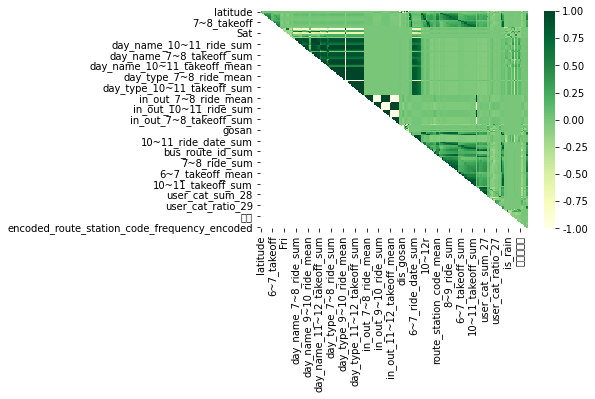

In [109]:
train_corr_triu = train_corr.where(np.triu(np.ones(train_corr.shape),k=1).astype(np.bool))
sns.heatmap(train_corr_triu,cmap=plt.cm.YlGn)

In [110]:
train_corr_btw_values = train_corr_triu.stack().reset_index()
train_corr_btw_values.columns = np.append(train_corr_btw_values.columns[:2],"correlation")
train_corr_btw_values

level_0  \
0                                          latitude   
1                                          latitude   
2                                          latitude   
3                                          latitude   
4                                          latitude   
...                                             ...   
16466        encoded_bus_route_id_frequency_encoded   
16467        encoded_bus_route_id_frequency_encoded   
16468        encoded_station_code_frequency_encoded   
16469        encoded_station_code_frequency_encoded   
16470  encoded_route_station_code_frequency_encoded   

                                            level_1  correlation  
0                                         longitude     0.134208  
1                                          6~7_ride     0.045578  
2                                          7~8_ride     0.067125  
3                                          8~9_ride     0.066391  
4                                         9~10_ride     0.065680  
...                                             ...          ...  
16466  encoded_route_station_code_frequency_encoded     0.083086  
16467                                    18~20_ride    -0.130082  
16468  encoded_route_station_code_frequency_encoded     0.016717  
16469                                    18~20_ride    -0.009255  
16470                                    18~20_ride    -0.004501  

[16471 rows x 3 columns]

##### Correlation with target value

In [111]:
train_corr_btw_values.loc[train_corr_btw_values["level_1"] == "18~20_ride"].loc[train_corr_btw_values.loc[train_corr_btw_values["level_1"] == "18~20_ride"]["correlation"].abs() > 0.8]

level_0     level_1  correlation
14640  route_station_code_mean  18~20_ride     0.836115
14700   route_station_code_sum  18~20_ride     0.833666

##### Correaltion btw non-target value

In [0]:
train_corr_btw_values_w_target = train_corr_btw_values.loc[train_corr_btw_values["level_1"] == "18~20_ride"]

In [0]:
train_corr_btw_values_wo_target = train_corr_btw_values.loc[train_corr_btw_values["level_1"] != "18~20_ride"]

##### 1. 독립변수 간의 상관관계를 활용한 컬럼 삭제

In [0]:
def delete_col_by_colinearity(df,df_w_target,df_wo_target,correlation=0.9):

  dummy = df_wo_target.loc[df_wo_target["correlation"] > 0.9]

  delete_col_list = []

  for idx,row in dummy.iterrows():
    column1 = "level_0"
    column2 = "level_1"
    column3 = "correlation"

    value1 = row[column1]
    value2 = row[column2]

    result_col1 = df_w_target.loc[df_w_target[column1] == value1][column1].values
    result_col2 = df_w_target.loc[df_w_target[column1] == value2][column1].values

    result_value1 = df_w_target.loc[df_w_target[column1] == value1][column3].values
    result_value2 = df_w_target.loc[df_w_target[column1] == value2][column3].values

    if np.abs(result_value1) < np.abs(result_value2):
      delete_col_list.append(result_col1[0])
    else:
      delete_col_list.append(result_col2[0])

  new_delete_col_list = list(set(delete_col_list))

  result = df.drop(new_delete_col_list,axis=1)

  return result

In [0]:
train_90_colinearity = delete_col_by_colinearity(train,train_corr_btw_values_w_target,train_corr_btw_values_wo_target)

회귀 추정 및 VIF 지표 측정

In [0]:
def get_OLS_VIF(data,target_col):

  import statsmodels.api as sm
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  from patsy import dmatrices

  dummy = data.copy()
  dummy2 = data.copy()

  vif_cols = data.columns

  x_columns = [ col for col in dummy.columns if target_col not in col ]
  y_column = target_col
  
  dummy["intercept"] = 1

  # https://intellipaat.com/community/19426/building-multi-regression-model-throws-error-pandas-data-cast-to-numpy-dtype-of-object-check-input-data-with-np-asarray-data
  lm = sm.OLS(dummy[y_column], dummy[["intercept"]+x_columns].astype("float"))
  OLS = lm.fit()

  from patsy.builtins import Q

  target_col = f"\'{target_col}\'"

  vif_func = f" Q({target_col}) ~ "

  for idx,column in enumerate(x_columns):
    if idx==0:
      vif_func+="Q(\'"+column+"\')"
    else:
      vif_func+="+"+"Q(\'"+column+"\')"

  # vif_func

  # # https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
  y, X = dmatrices(vif_func, dummy2, return_type = 'dataframe')

  vif = pd.DataFrame()
  vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  vif["features"] = X.columns 

  vif = vif.drop(vif.loc[vif["features"] == "Intercept"].index)

  return OLS,vif

In [0]:
OLS_90, VIF_90 = get_OLS_VIF(train_90_colinearity,"18~20_ride")

df_OLS_90 = OLS_90.params.reset_index()
df_OLS_90.columns = ["column_name","coef"]

OLS_90_corr = train_corr_btw_values_w_target.loc[train_corr_btw_values_w_target["level_0"].apply(lambda x: True if x in df_OLS_90["column_name"].to_list() else False)]
OLS_90_corr = OLS_90_corr.loc[:,["level_0","correlation"]]
OLS_90_corr.columns = ["column_name","corr"]

df_OLS_90_coef_corr = pd.merge(left=df_OLS_90,right=OLS_90_corr,on="column_name",how="inner")

df_OLS_90_coef_corr.to_csv(path+"OLS_coef_corr_90.csv")
VIF_90.to_csv(path+"Colinearity_90_VIF.csv")

##### 2. VIF 지표를 활용한 컬럼 삭제

In [0]:
def ref_vif_feature_selection(data,target_col,df_target_corr,vif_threshold=10):

  # About Threshold of VIF
  # https://www.researchgate.net/post/pValues_vs_VIF

  import statsmodels.api as sm
  from statsmodels.stats.outliers_influence import variance_inflation_factor
  from patsy import dmatrices
  from patsy.builtins import Q

  df = data.copy()

  result_dict = dict()

  is_stop = False

  x_columns = [col for col in df.columns if target_col not in col] 
  y_column = target_col

  df["intercept"] = 1

  while True:

    ref_vif_dict = dict()

    start = time.time()

    ref_vif_dict["columns"] = x_columns

    print(f"number of columns: {len(x_columns)}")
    print(f"remained columns: {x_columns}")

    # https://intellipaat.com/community/19426/building-multi-regression-model-throws-error-pandas-data-cast-to-numpy-dtype-of-object-check-input-data-with-np-asarray-data
    lm = sm.OLS(df[y_column],df[["intercept"]+x_columns].astype("float"))
    results = lm.fit()

    coefficient = results.params.reset_index()
    coefficient.columns = ["column_name","coef"]

    correaltion = df_target_corr.loc[:,["level_0","correlation"]]
    correaltion.columns = ["column_name","corr"]

    colinearity_check = pd.merge(left=correaltion,right=coefficient,on="column_name",how="inner")

    colinearity_causion_cols = []

    for idx,row in colinearity_check.iterrows():

      value1 = row["corr"] 
      value2 = row["coef"]

      if value1 >=0:
        result1 = True
      else:
        result1 = False

      if value2 >=0:
        result2 = True
      else:
        result2 = False

      if result1 == result2:
        continue

      else:
        colinearity_causion_cols.append(row["column_name"])

    if len(colinearity_causion_cols) !=0:
      print("there is something what not same (+/-) btw corr and coef still ")
      vif_func = " Q('18~20_ride') ~ "

      for idx,column in enumerate(x_columns):
        if idx==0:
          vif_func+="Q(\'"+column+"\')"
        else:
          vif_func+="+"+"Q(\'"+column+"\')"

      # # https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
      y, X = dmatrices(vif_func, df, return_type = 'dataframe')

      vif = pd.DataFrame()
      vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
      vif["features"] = X.columns 

      vif = vif.drop(vif.loc[vif["features"] == "Intercept"].index)
      
      vif_over_threshold = vif.loc[vif["VIF Factor"] > vif_threshold]

      if len(vif_over_threshold) == 0:
        print("there is no elements over VIF THRESHOLD")

        result = df.loc[:,x_columns+["18~20_ride"]]
        ref_vif_dict["max_vif"] = vif["VIF Factor"].max()
        result_dict[f"{len(x_columns)}"] = ref_vif_dict

        return result,result_dict
        
      else:
        vif_over_threshold_max = vif_over_threshold.loc[vif_over_threshold["VIF Factor"] == vif_over_threshold["VIF Factor"].max()]
        ref_vif_dict["max_vif"] = vif_over_threshold["VIF Factor"].max()

        over_threshold = vif_over_threshold_max["features"]
        over_threshold_series = over_threshold.apply(lambda x:re.findall(r"'(.*?)'",x)[0])

        over_threshold_list = over_threshold_series.values 

        over_threshold_corr = df_target_corr.loc[df_target_corr["level_0"].apply(lambda x: True if x in over_threshold_list else False)]

        over_threshold_corr = over_threshold_corr.sort_values(by="correlation",ascending=True)

        delete_column = over_threshold_corr.head(1)["level_0"].values

        # print(over_threshold_corr.head(1))
        # print(delete_column)
        # vif_over_threshold_max = vif_over_threshold_max.head(1)
        
        # delete_column = vif_over_threshold_max["features"].values[0]
        
        # delete_column = re.findall(r"'(.*?)'",delete_column)
        
        # delete_column = delete_column[0]

        result_dict[f"{len(x_columns)}"] = ref_vif_dict

        print(f"dropped column {delete_column}")

        x_columns.remove(delete_column)
        
        end = time.time()
        elapse_time_min = (end-start) // 60
        elapse_time_sec = round((end-start) % 60,2)
        print(f"elapse_time is {elapse_time_min} min {elapse_time_sec} sec")
        
    else:
      break

  result = df.loc[:,x_columns+["18~20_ride"]]
  return result,result_dict

In [0]:
# df_ref_vif_dropped,vif_dict = ref_vif_feature_selection(train_90_colinearity,"18~20_ride",train_corr_btw_values_w_target)

##### REF VIF Column Selector 결과

In [0]:
"""
number of columns: 84
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'day_type_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'in_out_11~12_takeoff_sum', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['day_type_11~12_ride_mean']
elapse_time is 6.0 min 25.79 sec
number of columns: 83
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'in_out_11~12_takeoff_sum', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['in_out_11~12_takeoff_sum']
elapse_time is 6.0 min 23.79 sec
number of columns: 82
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['Sun']
elapse_time is 5.0 min 59.17 sec
number of columns: 81
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Fri', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['Fri']
elapse_time is 6.0 min 10.57 sec
number of columns: 80
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['6~8t']
elapse_time is 5.0 min 42.66 sec
number of columns: 79
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['8~9_takeoff']
elapse_time is 5.0 min 36.96 sec
number of columns: 78
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['10~11_takeoff']
elapse_time is 5.0 min 5.04 sec
number of columns: 77
remained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['8~9_ride']
elapse_time is 5.0 min 35.32 sec
number of columns: 76
remained columns: ['latitude', 'longitude', '6~7_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['10~11_ride']
elapse_time is 4.0 min 53.53 sec
number of columns: 75
remained columns: ['latitude', 'longitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['user_cat_ratio_1']
elapse_time is 4.0 min 56.12 sec
number of columns: 74
remained columns: ['latitude', 'longitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', 'geton_vhc_passby_count', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['geton_vhc_passby_count']
elapse_time is 5.0 min 11.38 sec
number of columns: 73
remained columns: ['latitude', 'longitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['day_name_9~10_ride_mean']
elapse_time is 4.0 min 27.17 sec
number of columns: 72
remained columns: ['latitude', 'longitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['longitude']
elapse_time is 4.0 min 9.08 sec
number of columns: 71
remained columns: ['latitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['takeoff_sum']
elapse_time is 4.0 min 16.58 sec
number of columns: 70
remained columns: ['latitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'day_name_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['day_name_11~12_ride_mean']
elapse_time is 3.0 min 56.57 sec
number of columns: 69
remained columns: ['latitude', '6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['latitude']
elapse_time is 4.0 min 6.74 sec
number of columns: 68
remained columns: ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['jeju']
elapse_time is 3.0 min 53.45 sec
number of columns: 67
remained columns: ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'po', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
dropped column ['11~12_ride_date_sum']
elapse_time is 3.0 min 38.32 sec
number of columns: 66
remained columns: ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'po', '7~8_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded']
"""

"\nnumber of columns: 84\nremained columns: ['latitude', 'longitude', '6~7_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thr', 'Tue', 'is_holiday', 'day_name_9~10_ride_mean', 'day_name_11~12_ride_mean', 'day_type_11~12_ride_mean', 'in_out_8~9_takeoff_mean', 'in_out_11~12_takeoff_sum', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'jeju', 'po', 'takeoff_sum', '7~8_ride_date_sum', '11~12_ride_date_sum', '6~8r', '8~10r', '10~12r', '6~8t', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_1', 'user_cat_ra

In [0]:
remain_columns = ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'po', '7~8_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded'] + ["18~20_ride"]

df_ref_vif_dropped = train_90_colinearity.loc[:,remain_columns]

# df_ref_vif_dropped,vif_dict = ref_vif_feature_selection(train_90_colinearity.loc[:,remain_columns],"18~20_ride",train_corr_btw_values_w_target)

OLS_vif_dropped, VIF_vif_dropped = get_OLS_VIF(df_ref_vif_dropped,"18~20_ride")

df_OLS_VIF = OLS_vif_dropped.params.reset_index()
df_OLS_VIF.columns = ["column_name","coef"]

df_OLS_VIF_corr = train_corr_btw_values_w_target.loc[train_corr_btw_values_w_target["level_0"].apply(lambda x: True if x in df_OLS_VIF["column_name"].to_list() else False)]
df_OLS_VIF_corr = df_OLS_VIF_corr.loc[:,["level_0","correlation"]]
df_OLS_VIF_corr.columns = ["column_name","corr"]

df_OLS_VIF_coef_corr = pd.merge(left=df_OLS_VIF,right=df_OLS_VIF_corr,on="column_name",how="inner")

df_OLS_VIF_coef_corr.to_csv(path+"VIF_10_coef_corr.csv")
VIF_vif_dropped.to_csv(path+"VIF_10_Selected_VIF.csv")

In [0]:
OLS_vif_dropped.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             18~20_ride   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                 1.659e+04
Date:                Mon, 30 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:05:14   Log-Likelihood:            -9.6618e+05
No. Observations:              415423   AIC:                         1.932e+06
Df Residuals:                  415356   BIC:                         1.933e+06
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
intercept                                        0.5703      0.128      4.466      0.000       0.320       0.821
6~7_ride                                        -0.0090      0.007     -1.379      0.168      -0.022       0.004
9~10_ride                                        0.0110      0.004      2.440      0.015       0.002       0.020
11~12_ride                                       0.1480      0.005     30.397      0.000       0.138       0.158
6~7_takeoff                                      0.0136      0.010      1.419      0.156      -0.005       0.032
9~10_takeoff                                     0.0077      0.006      1.289      0.197      -0.004       0.019
11~12_takeoff                                    0.0150      0.006      2.330      0.020       0.002       0.028
day                                              0.0039      0.001      5.490      0.000       0.002       0.005
Mon                                              0.1744      0.020      8.854      0.000       0.136       0.213
Sat                                              0.1154      0.018      6.574      0.000       0.081       0.150
Thr                                              0.0313      0.018      1.697      0.090      -0.005       0.068
Tue                                              0.0416      0.015      2.739      0.006       0.012       0.071
is_holiday                                      -0.0593      0.021     -2.883      0.004      -0.100      -0.019
in_out_8~9_takeoff_mean                          0.0262      0.129      0.203      0.839      -0.227       0.280
dis_jeju                                        -0.0004      0.001     -0.552      0.581      -0.002       0.001
dis_seongsan                                     0.0001      0.001      0.226      0.822      -0.001       0.001
dis_po                                           0.0001      0.001      0.123      0.902      -0.002       0.002
gosan                                            0.0109      0.028      0.387      0.699      -0.044       0.066
po                                               0.0149      0.029      0.510      0.610      -0.042       0.072
7~8_ride_date_sum                             1.163e-05   1.25e-06      9.286      0.000    9.18e-06    1.41e-05
6~8r                                             0.0978      0.003     34.116      0.000       0.092       0.103
8~10r                                            0.1271      0.003     46.178      0.000       0.122       0.133
10~12r                                           0.1191      0.003     35.936      0.000       0.113       0.126
8~10t                                            0.1003      0.004     26.307      0.000       0.093       0.108
10~12t                          

In [0]:
VIF_vif_dropped

VIF Factor                                           features
1     1.960840                            Q('is_holiday')[T.True]
2     3.816053                               Q('is_rain')[T.True]
3     3.561132                                      Q('6~7_ride')
4     5.249525                                     Q('9~10_ride')
5     6.055980                                    Q('11~12_ride')
..         ...                                                ...
62    2.775059                                         Q('약한비계속')
63    1.961857                                         Q('약한비단속')
64    1.296986        Q('encoded_bus_route_id_frequency_encoded')
65    1.149224        Q('encoded_station_code_frequency_encoded')
66    1.254016  Q('encoded_route_station_code_frequency_encoded')

[66 rows x 2 columns]

#### 2. RFE를 활용한 Treemodel의 결과로 산출되는 Feature importance를 활용한 Selection

##### Permutation Importance

    https://www.kaggle.com/harangdev/feature-selection
    https://www.kaggle.com/dansbecker/permutation-importance
    https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html
    https://christophm.github.io/interpretable-ml-book/feature-importance.html

Permutation Importance는 '특정 feature를 사용불가능 상태로 만들었을 때 얼마나 예측점수가 감소했는지'를 활용하여 Importance를 측정합니다. 예를들어 X1~10까지의 독립변수가 있으며, 하나의 컬럼을 제거해가면서 학습을 하여 중요도를 측정하는 방식입니다. 하나의 컬럼을 제거 했을 때, 점수의 감소폭이 크다면, 그 컬럼은 결과값을 유추하는데 중요도가 큰 컬럼이 되는 것입니다. 

그런데 하나의 컬럼을 없애고 학습한다는 것은, 매번 컬럼을 제거하고 학습을 진행하기 때문에 매번 새로운 학습을 시켜야하는 문제점이 있습니다. 이때는 **제거해야할 컬럼을 random 하게 셔플함(Random Noise)으로써** 학습에 대한 내용을 '무력화'시키는 것입니다. 

그러나 해당 방법으로 컬럼을 계산하는것은 많은 Computing Power를 요함.

In [0]:
# y_true and y_pred is pd.Series datatype
def cust_rmse(y_true,y_pred):
  # pandas.Series 데이터 길이 일치 확인
  assert len(y_true) == len(y_pred)

  diff_btw_true_pred = (y_true - y_pred)
  diff_sqaured_btw_true_pred = diff_btw_true_pred**2
  mean_diff_squared_btw_true_pred = np.mean(diff_sqaured_btw_true_pred)
  root_mean_diff_squared_btw_true_pred = mean_diff_squared_btw_true_pred**0.5

  RMSE_result = root_mean_diff_squared_btw_true_pred

  return RMSE_result

In [0]:
# y_true and y_pred is pd.Series datatype
def cust_lgb_rmse(y_true,y_pred):
  # pandas.Series 데이터 길이 일치 확인
  assert len(y_true) == len(y_pred)

  diff_btw_true_pred = (y_true - y_pred)
  diff_sqaured_btw_true_pred = diff_btw_true_pred**2
  mean_diff_squared_btw_true_pred = np.mean(diff_sqaured_btw_true_pred)
  root_mean_diff_squared_btw_true_pred = mean_diff_squared_btw_true_pred**0.5

  RMSE_result = root_mean_diff_squared_btw_true_pred

  return "lgb_rmse",RMSE_result,False

In [0]:
from sklearn.model_selection import train_test_split 
from eli5.sklearn import PermutationImportance
import shap

def rfe(X,target_col,method,ratio=0.9,min_feats=30):  

  X_data = X.copy()

  y =  X_data[target_col]
  X_data = X_data.drop(target_col,axis=1)
  
  columns = X_data.columns.tolist() 

  # result_dataframe = pd.DataFrame(columns=["model","n_feats","feats","score"])
  result_list = list()


  while True:

    result_dict = dict()
    print(f"{method} / {ratio} processing... \ncolumns now {len(columns)} target columns {min_feats}")
    
    model = LGBMRegressor(learning_rate=0.001,n_estimators=1000)
    X_train, X_valid, y_train, y_valid = train_test_split(X_data.loc[:,columns],y,random_state=0,shuffle=True)
    model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)], eval_names=["train","valid"], eval_metric = cust_lgb_rmse, early_stopping_rounds=250,verbose=200)
    val_pred = model.predict(X_valid)
    score = cust_rmse(y_valid,val_pred)
    n_feats = len(columns)

    # result_dataframe.append({"model":model, "n_feats":n_feats, "feats":columns, "score":score},ignore_index=True)
    # result_dataframe["model"] = "hello"
    result_dict["n_feats"] = n_feats
    result_dict["model"] = model
    result_dict["feats"] = columns
    result_dict["score"] = score
    
    result_list.append(result_dict)

    start = time.time()

    if method == "perm":
      perm = PermutationImportance(model, random_state=101).fit(X_valid,y_valid)
      feat_imp = pd.Series(perm.feature_importances_,index=columns).sort_values(ascending=False)

    elif method == "shap":
      explainer = shap.TreeExplainer(model)
      shap_values = explainer.shap_values(X_data[columns])
      feat_imp = pd.Series(np.abs(shap_values).mean(axis=0),index=columns).sort_values(ascending=False)

    end = time.time()

    elapse_time_min = (end-start) // 60
    elapse_time_sec = round((end-start) % 60,2)
    print(f"elapse_time is {elapse_time_min} min {elapse_time_sec} sec")

    next_n_feats = int(n_feats * ratio)
    if next_n_feats < min_feats:
      break
    else:
      columns = feat_imp.iloc[:next_n_feats].index.tolist()

  # return result_dataframe 
  result = pd.DataFrame(result_list)
  return result

In [0]:
# result_dataframe = rfe(df_ref_vif_dropped,"18~20_ride","perm")
# result_dataframe.to_csv(path+"PermutationImportance_REF.csv")

df_permutation_ref = pd.read_csv(path+"PermutationImportance_REF.csv")

In [80]:
df_permutation_ref

Unnamed: 0  n_feats                                              model  \
0           0       66  LGBMRegressor(boosting_type='gbdt', class_weig...   
1           1       59  LGBMRegressor(boosting_type='gbdt', class_weig...   
2           2       53  LGBMRegressor(boosting_type='gbdt', class_weig...   
3           3       47  LGBMRegressor(boosting_type='gbdt', class_weig...   
4           4       42  LGBMRegressor(boosting_type='gbdt', class_weig...   
5           5       37  LGBMRegressor(boosting_type='gbdt', class_weig...   
6           6       33  LGBMRegressor(boosting_type='gbdt', class_weig...   

                                               feats     score  
0  ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_t...  2.625216  
1  ['route_station_code_mean', '7~8_ride_date_sum...  2.625960  
2  ['route_station_code_mean', '7~8_ride_date_sum...  2.625444  
3  ['route_station_code_mean', '7~8_ride_date_sum...  2.625444  
4  ['route_station_code_mean', '7~8_ride_date_sum...  2.625444  
5  ['route_station_code_mean', '7~8_ride_date_sum...  2.625444  
6  ['route_station_code_mean', '7~8_ride_date_sum...  2.625656

ERROR! Session/line number was not unique in database. History logging moved to new session 59


##### SHAP value


In [124]:
# remain_columns = ['6~7_ride', '9~10_ride', '11~12_ride', '6~7_takeoff', '9~10_takeoff', '11~12_takeoff', 'day', 'Mon', 'Sat', 'Thr', 'Tue', 'is_holiday', 'in_out_8~9_takeoff_mean', 'dis_jeju', 'dis_seongsan', 'dis_po', 'gosan', 'po', '7~8_ride_date_sum', '6~8r', '8~10r', '10~12r', '8~10t', '10~12t', 'bus_route_id_mean', 'station_code_mean', 'station_code_sum', 'route_station_code_mean', 'congestion', '6~7_ride_sum', '7~8_ride_sum', '8~9_ride_sum', '9~10_ride_sum', '10~11_ride_sum', '11~12_ride_sum', '6~7_takeoff_sum', '7~8_takeoff_sum', '8~9_takeoff_sum', '9~10_takeoff_sum', '10~11_takeoff_sum', '11~12_takeoff_sum', 'user_cat_sum_2', 'user_cat_sum_4', 'user_cat_sum_30', 'user_cat_ratio_2', 'user_cat_ratio_4', 'user_cat_ratio_6', 'user_cat_ratio_27', 'user_cat_ratio_28', 'user_cat_ratio_29', 'user_cat_ratio_30', '현재기온_10', '일강수_10', 'is_rain', '구름많음', '구름조금', '맑음', '박무', '보통비계속', '비 끝남', '소나기 끝', '약한비계속', '약한비단속', 'encoded_bus_route_id_frequency_encoded', 'encoded_station_code_frequency_encoded', 'encoded_route_station_code_frequency_encoded'] + ["18~20_ride"]

# df_ref_vif_dropped = train_90_colinearity[remain_columns]

# result_dataframe = rfe(df_ref_vif_dropped,"18~20_ride","shap")
# result_dataframe.to_csv(path+"SHAP_REF.csv")

df_shap_ref = pd.read_csv(path+"SHAP_REF.csv")

shap / 0.9 processing... 
columns now 66 target columns 30
Training until validation scores don't improve for 250 rounds.
[200]	train's l2: 17.0695	train's lgb_rmse: 4.13153	valid's l2: 15.6522	valid's lgb_rmse: 3.95628
[400]	train's l2: 13.2525	train's lgb_rmse: 3.6404	valid's l2: 12.0113	valid's lgb_rmse: 3.46573
[600]	train's l2: 10.6293	train's lgb_rmse: 3.26027	valid's l2: 9.59758	valid's lgb_rmse: 3.098
[800]	train's l2: 8.79173	train's lgb_rmse: 2.96509	valid's l2: 7.97848	valid's lgb_rmse: 2.82462
[1000]	train's l2: 7.53107	train's lgb_rmse: 2.74428	valid's l2: 6.89176	valid's lgb_rmse: 2.62522
Did not meet early stopping. Best iteration is:
[1000]	train's l2: 7.53107	train's lgb_rmse: 2.74428	valid's l2: 6.89176	valid's lgb_rmse: 2.62522
elapse_time is 11.0 min 47.64 sec
shap / 0.9 processing... 
columns now 59 target columns 30
Training until validation scores don't improve for 250 rounds.
[200]	train's l2: 17.0695	train's lgb_rmse: 4.13153	valid's l2: 15.6522	valid's lgb_rms

In [125]:
result_dataframe

n_feats                                              model  \
0       66  LGBMRegressor(boosting_type='gbdt', class_weig...   
1       59  LGBMRegressor(boosting_type='gbdt', class_weig...   
2       53  LGBMRegressor(boosting_type='gbdt', class_weig...   
3       47  LGBMRegressor(boosting_type='gbdt', class_weig...   
4       42  LGBMRegressor(boosting_type='gbdt', class_weig...   
5       37  LGBMRegressor(boosting_type='gbdt', class_weig...   
6       33  LGBMRegressor(boosting_type='gbdt', class_weig...   

                                               feats     score  
0  [6~7_ride, 9~10_ride, 11~12_ride, 6~7_takeoff,...  2.625216  
1  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625216  
2  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625216  
3  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625216  
4  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625216  
5  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625143  
6  [route_station_code_mean, 7~8_ride_date_sum, M...  2.625524

In [98]:
train_90_colinearity

latitude  longitude  6~7_ride  8~9_ride  9~10_ride  10~11_ride  \
0       33.48990  126.49373       0.0       2.0        5.0         2.0   
1       33.48944  126.48508       1.0       4.0        2.0         5.0   
2       33.48181  126.47352       1.0       0.0        2.0         0.0   
3       33.50577  126.49252       0.0       6.0       26.0        14.0   
4       33.25579  126.41260       0.0       0.0        0.0         0.0   
...          ...        ...       ...       ...        ...         ...   
415418  33.41437  126.26336       4.0       0.0        0.0         0.0   
415419  33.49946  126.51479       4.0       0.0        0.0         0.0   
415420  33.23100  126.26273       0.0       0.0        0.0         0.0   
415421  33.46483  126.31870       1.0       0.0        0.0         0.0   
415422  33.24873  126.50799       0.0       0.0        0.0         0.0   

        11~12_ride  6~7_takeoff  8~9_takeoff  9~10_takeoff  10~11_takeoff  \
0              6.0          0.0          0.0           0.0            0.0   
1              6.0          0.0          0.0           0.0            0.0   
2              0.0          0.0          0.0           0.0            0.0   
3             16.0          0.0          0.0           0.0            0.0   
4              0.0          0.0          0.0           1.0            0.0   
...            ...          ...          ...           ...            ...   
415418         0.0          0.0          0.0           0.0            0.0   
415419         0.0          0.0          0.0           0.0            0.0   
415420         0.0          0.0          0.0           0.0            0.0   
415421         0.0          0.0          0.0           0.0            0.0   
415422         0.0          0.0          4.0           0.0            0.0   

        11~12_takeoff  day  Fri  Mon  Sat  Sun  Thr  Tue  is_holiday  \
0                 0.0    1  0.0  0.0  0.0  1.0  0.0  0.0       False   
1                 0.0    1  0.0  0.0  0.0  1.0  0.0  0.0       False   
2                 0.0    1  0.0  0.0  0.0  1.0  0.0  0.0       False   
3                 0.0    1  0.0  0.0  0.0  1.0  0.0  0.0       False   
4                 0.0    1  0.0  0.0  0.0  1.0  0.0  0.0       False   
...               ...  ...  ...  ...  ...  ...  ...  ...         ...   
415418            0.0   30  0.0  1.0  0.0  0.0  0.0  0.0       False   
415419            0.0   30  0.0  1.0  0.0  0.0  0.0  0.0       False   
415420            0.0   30  0.0  1.0  0.0  0.0  0.0  0.0       False   
415421            0.0   30  0.0  1.0  0.0  0.0  0.0  0.0       False   
415422            0.0   30  0.0  1.0  0.0  0.0  0.0  0.0       False   

        day_name_9~10_ride_mean  day_name_11~12_ride_mean  \
0                      0.531006                  0.552089   
1                      0.531006                  0.552089   
2                      0.531006                  0.552089   
3                      0.531006                  0.552089   
4                      0.531006                  0.552089   
...                         ...                       ...   
415418                 0.692790                  0.597506   
415419                 0.692790                  0.597506   
415420                 0.692790                  0.597506   
415421                 0.692790                  0.597506   
415422                 0.692790                  0.597506   

        day_type_11~12_ride_mean  in_out_8~9_takeoff_mean  \
0                       0.580062                 0.753286   
1                       0.580062                 0.753286   
2                       0.580062                 0.753286   
3                       0.580062                 0.512468   
4                       0.580062                 0.512468   
...                          ...                      ...   
415418                  0.579186                 0.512468   
415419                  0.579186                 0.512468   
415420                  0.579186               